# Чтение HDF5 и преобразование дифференциальной фазы в обычную

In [1]:
# Импорт необходимых библиотек
import numpy as np
import h5py
import scipy.signal as signal
import matplotlib.pyplot as plt

In [9]:
# Чтение файла с данными
file_name = "Melody P1.hdf5"

# Диапазон индексов для вывода данных
from_index = 0
to_index = 10000

# Соличество кривых для отображения
curves_output_count = 20

# Чтение файла с дифференциальной фазой и метеданными
with h5py.File(file_name, 'r', libver='latest') as h5_file:
    data_dphase = h5_file.get('DAS')[from_index:to_index, :curves_output_count]
    start_time = h5_file['Metadata/Timestamp'][0]
    pulse_rate = h5_file['DAQ/RepetitionFrequency'][0]
    start_distance = h5_file['DAQ/PositionStart'][0]
    end_distance = h5_file['DAQ/PositionEnd'][0]
    
# Интегрирование дифференциальной фазы для получения обычной фазы и преобразование её а радианы
data_phase = np.cumsum(data_dphase, axis=0) * (np.pi / 2 ** 15)
# Пример 4 Гц фильтра верхних частот
cutoff = 4 # параметр фильтра в Гц
nyq = pulse_rate / 2 # Частота Найквиста
b, a = signal.butter(5, cutoff / nyq, btype='high', analog=False)
data_highpass_phase = signal.filtfilt(b, a, data_phase)

# Генерация вектора расстояний
dist = np.arange(start_distance, end_distance, (end_distance-start_distance)/data_highpass_phase.shape[0])

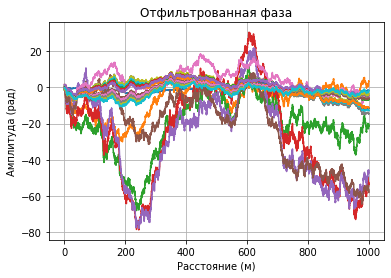

In [10]:
# Вывод графика
fig, ax = plt.subplots()

# Отображение графика
ax.plot(dist[from_index:to_index], data_highpass_phase[from_index:to_index,:curves_output_count])
ax.set(xlabel='Расстояние (м)', ylabel='Амплитуда (рад)',
       title='Отфильтрованная фаза')
ax.grid()
plt.show()

In [11]:
# Подготовка для сохранения данных
data_highpass_phase_n_dist=np.zeros((data_highpass_phase.shape[0],data_highpass_phase.shape[1]+1))

data_highpass_phase_n_dist[:,1:] = data_highpass_phase
data_highpass_phase_n_dist[:,0] = dist

In [12]:
# Сохранение в txt
np.savetxt("DAS.txt", data_highpass_phase_n_dist[from_index:to_index,:curves_output_count], fmt='%-7.2f')

# Конец